In [1]:
import pandas as pd
import seaborn as sns

#### Import AFT Data set

##### mentorship

In [3]:
Mtoship = pd.read_csv('chemistry.csv')

In [4]:
Mtoship.sample(1)

,Unnamed: 0,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear
75027,521934,1203426,634921,70097,2,Cincinnati Children's Hospital and Medical Ce...,NaN,2014,2017


<Axes: xlabel='StopYear', ylabel='Count'>

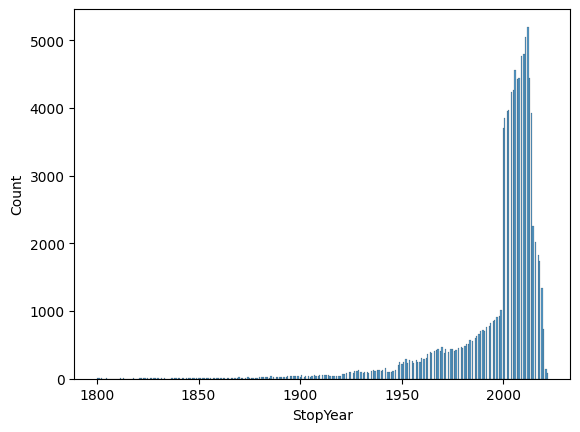

In [5]:
sns.histplot(data=Mtoship, x="StopYear",binrange=[1800,2022])

In [6]:
len(Mtoship[Mtoship.StopYear!=-1])/len(Mtoship)

0.8016881459838584

In [7]:
Mentor_StopYear = Mtoship[['MentorID','StopYear']][Mtoship.StopYear!=-1]

In [8]:
Mentor_StopYear.head(5)

,MentorID,StopYear
0,9,1984
1,33687,1997
3,52639,1971
4,189,1927
6,223,1871


In [9]:
idx = Mentor_StopYear.groupby(['MentorID'])['StopYear'].transform(min) == Mentor_StopYear['StopYear'] #choose the minimum StopYear 
Mentor_FirstYear = Mentor_StopYear[idx]

In [10]:
Mentor_FirstYear = Mentor_FirstYear.rename(columns={'StopYear':'FirstMenteeYear'})

In [11]:
Mentor_FirstYear.head(5)

,MentorID,FirstMenteeYear
1,33687,1997
3,52639,1971
7,87777,1842
14,339,1932
15,339,1932


In [12]:
len(Mentor_FirstYear)

28964

<Axes: xlabel='FirstMenteeYear', ylabel='Probability'>

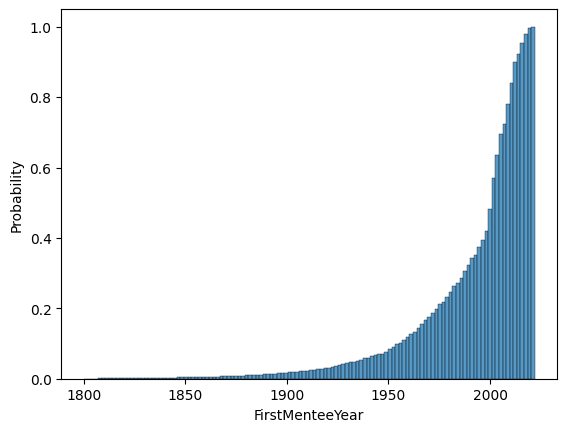

In [13]:
sns.histplot(data=Mentor_FirstYear, x="FirstMenteeYear",binrange=[1800,2022],stat='probability',cumulative=True)

Check the result above

In [14]:
Mentor_FirstYear.to_csv('Mentor_FirstMenteeYear.csv',index=0)

##### researcher

In [15]:
PeoInfo = pd.read_csv('researcher.csv')

In [16]:
PeoInfo.sample(1)

,PID,FirstName,MiddleName,LastName,Institution,InstitutionMAGID,ResearchArea,ORCID,MAGAuthorID
374728,406023,ZHE,NaN,CHENG,Georgia Institute of Technology,130701444.0,math,NaN,2.401828e+09


In [22]:
PeoInfo.shape

(774733, 9)

In [17]:
PeoInfo = PeoInfo.rename(columns={'PID':'MentorID'})

In [18]:
Mentor_FirstYear = Mentor_FirstYear.merge(PeoInfo, on='MentorID',how='left')[['MentorID','MAGAuthorID','FirstMenteeYear']]

In [19]:
Mentor_FirstYear = Mentor_FirstYear[~Mentor_FirstYear.MAGAuthorID.isnull()]

In [20]:
Mentor_FirstYear

,MentorID,MAGAuthorID,FirstMenteeYear
1,52639,2.619948e+09,1971
3,339,2.165067e+09,1932
4,339,2.165067e+09,1932
5,51265,1.987742e+09,1982
6,189,2.152986e+09,1910
...,...,...,...
28958,839557,2.079478e+09,1994
28960,351345,2.143182e+09,1978
28961,351345,2.143182e+09,1978
28962,97262,2.155241e+09,1992


In [23]:
magId = [int(k) for k in list(Mentor_FirstYear.MAGAuthorID)]

In [24]:
from sqlalchemy import create_engine
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}?charset=utf8mb4"
                       .format(user="openalex_ym",
                               pw="openalex.ym",
                               host="172.18.18.167",
                               port=3306,
                               db="openalex2022"),
                       )

In [25]:
magId_groups = []
interval = 5000
start_point = 0
while True:
    end_point = start_point + interval
    try:
        temp = magId[start_point:end_point]
        magId_groups.append(temp)
    except:
        temp = magId[start_point:]
        magId_groups.append(temp)
        
    start_point = end_point
    if end_point>len(magId):
        break

In [26]:
print(len(magId_groups))

6


In [27]:
l = len(magId_groups)
for i in range(l):
    temp =  magId_groups[i]
    sql_query = """select authors_ids.author_id, authors_ids.mag 

                    from authors_ids 

                    where authors_ids.mag in {}
                    """.format(tuple(temp))


    data = pd.read_sql(sql_query, con=engine)
    # merge data
    if i==0:
        tp = data
    else:
        tp = pd.concat((tp,data))

data = tp

In [28]:
data = data.rename(columns={'mag':'MAGAuthorID'})

In [29]:
data

,author_id,MAGAuthorID
0,A367921,367921
1,A1199224,1199224
2,A1495678,1495678
3,A2191649,2191649
4,A2229241,2229241
...,...,...
287,A2957634552,2957634552
288,A2984796274,2984796274
289,A3032105808,3032105808
290,A3045494378,3045494378


In [30]:
data = data.merge(Mentor_FirstYear,on='MAGAuthorID',how='left')

In [31]:
data = data.rename(columns={'MentorID':'AFTMentorID'})

In [32]:
data

,author_id,MAGAuthorID,AFTMentorID,FirstMenteeYear
0,A367921,367921,2488,2000
1,A1199224,1199224,95661,2009
2,A1495678,1495678,51349,1963
3,A2191649,2191649,62912,2005
4,A2191649,2191649,62912,2005
...,...,...,...,...
25722,A2957634552,2957634552,737952,2005
25723,A2984796274,2984796274,59514,1963
25724,A3032105808,3032105808,837913,2012
25725,A3045494378,3045494378,834800,2012


In [33]:
data.to_csv('target_author.csv',index=0)